## 1. Document/Text Processing and Embedding Creation

Ingredients:
* PDF document of choice.
* Embedding model of choice.

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use (embeddings will store on file for many years or until you lose your hard drive).

### Import PDF Document 

This will work with many other kinds of documents.

However, we'll start with PDF since many people have PDFs.

But just keep in mind, text files, email chains, support documentation, articles and more can also work.

We're going to pretend we're nutrition students at the University of Hawai'i, reading through the open-source PDF textbook [*Human Nutrition: 2020 Edition*](https://pressbooks.oer.hawaii.edu/humannutrition2/).

There are several libraries to open PDFs with Python but I found that [PyMuPDF](https://github.com/pymupdf/pymupdf) works quite well in many cases.

First we'll download the PDF if it doesn't exist.

In [3]:
import os
import requests
import pandas as pd

In [4]:
# Get PDF document path
filename = "human-nutrition-text.pdf"

# Download PDF
if not os.path.exists(filename):
    print("File doesn't exist, downloading...")
    
    # The URL of the PDF you want to download
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    # Send a GET request to the url
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the file and save it
        with open(filename,"wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been download and saved as {filename}")
    else: print(f"[INFO] Failed to download the file. Status Code: {response.status_code}")
        
else:
  print(f"File {filename} exists.")

File human-nutrition-text.pdf exists.


PDF acquired!

We can import the pages of our PDF to text by first defining the PDF path and then opening and reading it with PyMuPDF (`import fitz`).

We'll write a small helper function to preprocess the text as it gets read. Note that not all text will be read in the same so keep this in mind for when you prepare your text.

We'll save each page to a dictionary and then append that dictionary to a list for ease of use later.

In [5]:
import fitz # install PyMuPDF
from tqdm import tqdm

# Format text read from PDF
def text_formatter(text: str) -> str:
    cleaned_text = text.replace("\n"," ").strip()
    return cleaned_text

# Provide pdf name
def open_and_read_pdf(filename: str)->list[dict]:
    doc = fitz.open(filename)
    pages_and_texts=[]
    for page_number,page in tqdm(enumerate(doc)):
        text = page.get_text()
        formatted_text = text_formatter(text)

        # store pages information and texts in a dictionary
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                        "page_char_count": len(text),
                        "page_word_count": len(text.split(" ")),
                        "page_sentence_count_raw": len(text.split(". ")),
                        # "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                        "text": text})
        
    return pages_and_texts

def read_pages(pages,page_number:int):
    content  = pages[page_number+41]
    return content

In [6]:
pages_and_texts = open_and_read_pdf("human-nutrition-text.pdf")
content = read_pages(pages_and_texts,50)
content

1208it [00:00, 1328.97it/s]


{'page_number': 50,
 'page_char_count': 1128,
 'page_word_count': 165,
 'page_sentence_count_raw': 12,
 'text': 'attention of an unsuspecting consumer. Track down the \noriginal journal article to see if it really supports the \nconclusions being drawn in the news report. \nWhen reading information on websites, remember the following \ncriteria for discerning if the site is valid: \n1. Who sponsors the website? \n2. Are names and credentials disclosed? \n3. Is an editorial board identified? \n4. Does the site contain links to other credible informational \nwebsites? \n5. Even better, does it reference peer-reviewed journal articles? \nIf so, do those journal articles actually back up the claims being \nmade on the website? \n6. How often is the website updated? \n7. Are you being sold something at this website? \n8. Does the website charge a fee? \nFor \nmore \ninformation, \nvisit \nhttp://www.csuchico.edu/lins/\nhandouts/eval_websites.pdf \nTrustworthy Sources \nNow let’s consider so

# Get some stats on the text
Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.

Many embedding models have limits on the size of texts they can ingest, for example, the `sentence-transformers` model `all-mpnet-base-v2` has an input size of 384 tokens.

<b>we can use an embedding model of larger size but it would take up a lot of resources (huge model size)</b>

This means that the model has been trained in ingest and turn into embeddings texts with 384 tokens (1 token ~= 4 characters ~= 0.75 words).

Texts over 384 tokens which are encoded by this model will be auotmatically reduced to 384 tokens in length, potentially losing some information.

We'll discuss this more in the embedding section.

For now, let's further break the texts into sentences

### Further text processing (splitting pages into sentences)

The ideal way of processing text before embedding it is still an active area of research.

A simple method I've found helpful is to break the text into chunks of sentences.

As in, chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

> **Resource:** See [spaCy install instructions](https://spacy.io/usage). 

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`. 

<b>Why use Spacy sentencizer?</b>
* Better than split by `'.'`

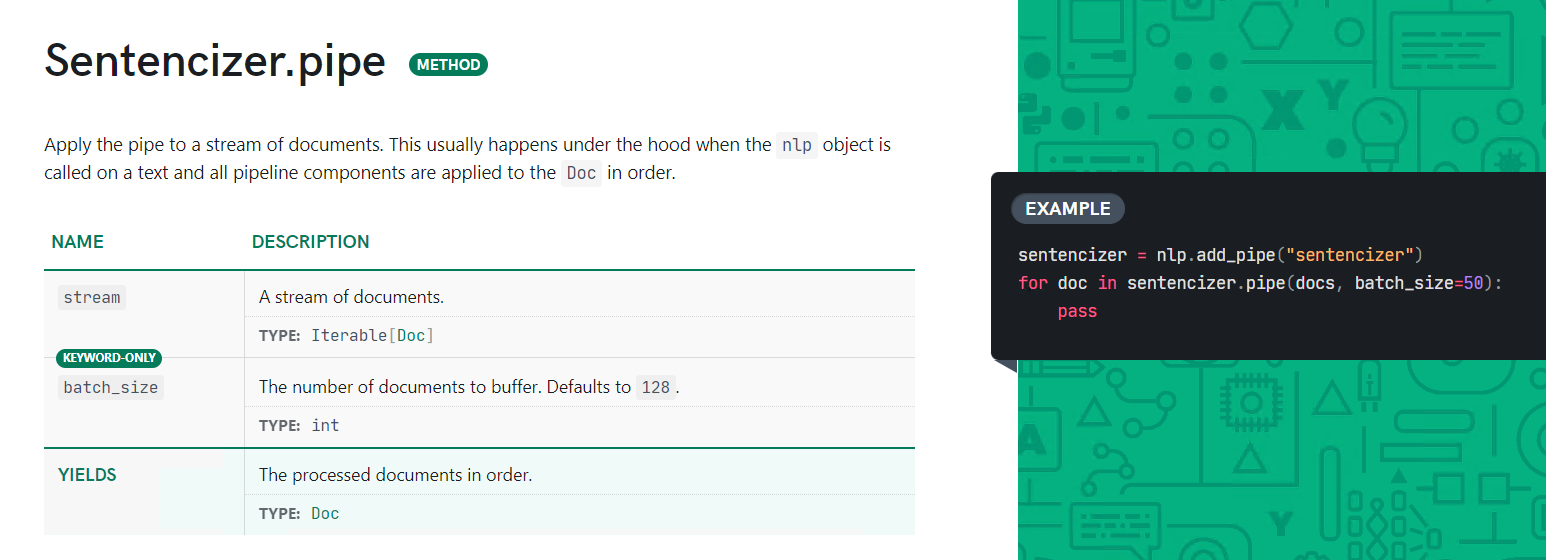

In [7]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

We don't necessarily need to use spaCy, however, it's an open-source library designed to do NLP tasks like this at scale.

So let's run our small sentencizing pipeline on our pages of text.

In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

100%|██████████| 1208/1208 [00:01<00:00, 823.90it/s]


In [14]:
read_pages(pages_and_texts,100)

{'page_number': 100,
 'page_char_count': 930,
 'page_word_count': 143,
 'page_sentence_count_raw': 8,
 'text': 'Major organs \nof the \nrespiratory \nsystem \n \nThe major respiratory structures span the nasal cavity to the \ndiaphragm. Functionally, the respiratory system can be divided into \na conducting zone and a respiratory zone. The conducting zone \nof the respiratory system includes the organs and structures not \ndirectly involved in gas exchange (trachea and bronchi). The gas \nexchange occurs in the respiratory zone. \nConducting Zone \nThe major functions of the conducting zone are to provide a route \nfor incoming and outgoing air, remove debris and pathogens from \nthe incoming air, and warm and humidify the incoming air. Several \nstructures within the conducting zone perform other functions as \nwell. The epithelium of the nasal passages, for example, is essential \nto sensing odors, and the bronchial epithelium that lines the lungs \ncan metabolize some airborne carci

In [9]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

100%|██████████| 1208/1208 [00:00<00:00, 347511.61it/s]


In [13]:
read_pages(pages_and_texts,100)

{'page_number': 100,
 'page_char_count': 930,
 'page_word_count': 143,
 'page_sentence_count_raw': 8,
 'text': 'Major organs \nof the \nrespiratory \nsystem \n \nThe major respiratory structures span the nasal cavity to the \ndiaphragm. Functionally, the respiratory system can be divided into \na conducting zone and a respiratory zone. The conducting zone \nof the respiratory system includes the organs and structures not \ndirectly involved in gas exchange (trachea and bronchi). The gas \nexchange occurs in the respiratory zone. \nConducting Zone \nThe major functions of the conducting zone are to provide a route \nfor incoming and outgoing air, remove debris and pathogens from \nthe incoming air, and warm and humidify the incoming air. Several \nstructures within the conducting zone perform other functions as \nwell. The epithelium of the nasal passages, for example, is essential \nto sensing odors, and the bronchial epithelium that lines the lungs \ncan metabolize some airborne carci

In [15]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

100%|██████████| 1208/1208 [00:00<00:00, 35183.84it/s]


1843

In [25]:
read_pages(pages_and_texts,190)

{'page_number': 190,
 'page_char_count': 1305,
 'page_word_count': 197,
 'page_sentence_count_raw': 11,
 'text': 'Chloride \nUNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN \nNUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM \nChloride is the primary anion in extracellular fluid. In addition to \npassively following sodium, chloride has its own protein channels \nthat reside in cell membranes. These protein channels are especially \nabundant in the gastrointestinal tract, pancreas, and lungs. \nChloride’s Role in Fluid Balance \nChloride aids in fluid balance mainly because it follows sodium in \norder to maintain charge neutrality. Chloride channels also play a \nrole in regulating fluid secretion, such as pancreatic juice into the \nsmall intestine and the flow of water into mucus. Fluid secretion and \nmucus are important for many of life’s processes. Their importance \nis exemplified in the signs and symptoms of the genetic disease, \ncystic fibrosis. \nCystic Fibrosis \nCystic f

In [28]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')
else: print('#'*50)

# Filter out our list of dictionaries to include only chunks with over 30 tokens in length
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

Chunk token count: 9.5 | Text: 742 | Building Healthy Eating Patterns
Chunk token count: 3.5 | Text: Fluoride | 697
Chunk token count: 19.5 | Text: http://pressbooks.oer.hawaii.edu/
humannutrition2/?p=463 
 
870 | Introduction
Chunk token count: 18.0 | Text: Table 6.1 Essential and Nonessential Amino Acids 
Defining Protein | 365
Chunk token count: 6.5 | Text: Fat-Soluble Vitamins | 537
##################################################


[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 \nEdition \nUNIVERSITY OF HAWAI‘I AT MĀNOA \nFOOD SCIENCE AND HUMAN \nNUTRITION PROGRAM \nALAN TITCHENAL, SKYLAR HARA, \nNOEMI ARCEO CAACBAY, WILLIAM \nMEINKE-LAU, YA-YUN YANG, MARIE \nKAINOA FIALKOWSKI REVILLA, \nJENNIFER DRAPER, GEMADY \nLANGFELDER, CHERYL GIBBY, CHYNA \nNICOLE CHUN, AND ALLISON \nCALABRESE',
  'chunk_char_count': 320,
  'chunk_word_count': 42,
  'chunk_token_count': 80.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program is licensed under a Creative Commons Attribution 4.0 \nInternational License, except where otherwise noted.',
  'chunk_char_count': 212,
  'chunk_word_count': 30,
  'chunk_token_count': 53.0}]